In [20]:
# Lung Cancer Detection through Air Pollution using Machine Learning(Multi-algorithm)

# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, roc_curve,
                             mean_absolute_error, mean_squared_error, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')


In [21]:
#Step 2: Load Dataset
df = pd.read_csv("cancer patient data sets.csv")

# Step 3: Encode categorical columns
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

# Step 4: Drop leakage-prone features
leakage_cols = ['Smoking', 'Balanced Diet', 'Air Pollution', 'Obesity',
                'Passive Smoker', 'Coughing of Blood']
df.drop(columns=leakage_cols, inplace=True)

# Step 5: Define features and target
X = df.drop(['Level', 'Patient Id'], axis=1)
y = df['Level']

In [22]:
# Step 6: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 7: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 8: Train Multiple Models
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(probability=True, class_weight='balanced')
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    if len(np.unique(y_test)) > 2:
        y_test_bin = label_binarize(y_test, classes=np.unique(y))
        probs = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test_bin, probs, average="macro", multi_class="ovr")
    else:
        probs = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, probs)

    results[name] = {
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds, average='weighted'),
        "Recall": recall_score(y_test, preds, average='weighted'),
        "F1 Score": f1_score(y_test, preds, average='weighted'),
        "ROC AUC": roc_auc
    }

# Step 9: Best Model Selection
results_df = pd.DataFrame(results).T
best_model_name = results_df["ROC AUC"].idxmax()
best_model = models[best_model_name]
print("\n✅ Best Model After Fixing Leakage:", best_model_name)



✅ Best Model After Fixing Leakage: Logistic Regression


In [23]:
# Step 10: Hyperparameter Tuning
param_grid = {}
if best_model_name == "Random Forest":
    param_grid = {"n_estimators": [50, 100]}
elif best_model_name == "Gradient Boosting":
    param_grid = {"learning_rate": [0.01, 0.1]}
elif best_model_name == "SVM":
    param_grid = {"C": [0.1, 1]}
else:
    param_grid = {"C": [0.01, 0.1, 1]}

grid = GridSearchCV(best_model, param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)
best_model = grid.best_estimator_


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90        82
           1       0.96      0.89      0.92        55
           2       0.93      0.84      0.88        63

    accuracy                           0.90       200
   macro avg       0.91      0.89      0.90       200
weighted avg       0.90      0.90      0.90       200


📉 Confusion Matrix:


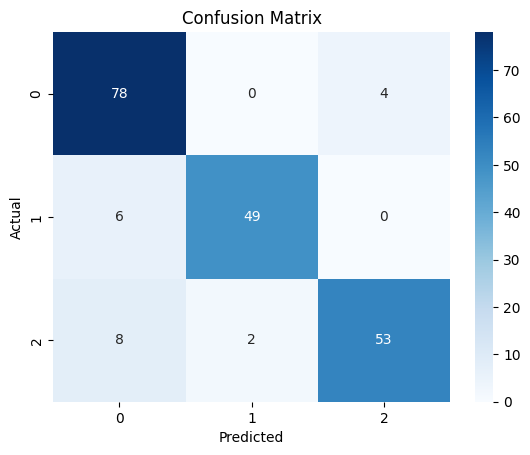

In [24]:
# Step 11: Evaluation
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("\n📉 Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [25]:
# Step 12: Error Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"\nMAE: {mae:.4f} | MSE: {mse:.4f} | RMSE: {rmse:.4f}")


MAE: 0.1600 | MSE: 0.2800 | RMSE: 0.5292


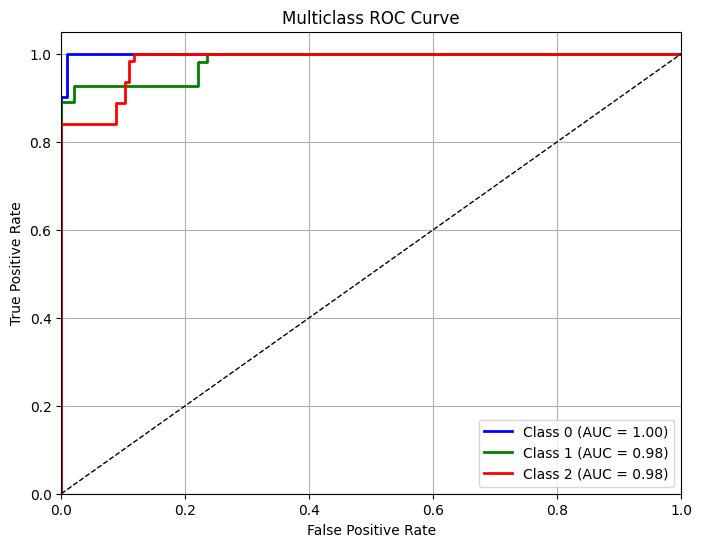

In [26]:
# Step 13: ROC Curve (Multiclass)
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
y_score = best_model.predict_proba(X_test)
n_classes = y_test_binarized.shape[1]

plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    auc_score = roc_auc_score(y_test_binarized[:, i], y_score[:, i])
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'Class {i} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [27]:
# Step 14: Model Comparison Table
print("\n🔍 Model Comparison (sorted by ROC AUC):")
display(results_df.sort_values("ROC AUC", ascending=False))


🔍 Model Comparison (sorted by ROC AUC):


,Accuracy,Precision,Recall,F1 Score,ROC AUC
Logistic Regression,1.0,1.0,1.0,1.0,1.0
Random Forest,1.0,1.0,1.0,1.0,1.0
Gradient Boosting,1.0,1.0,1.0,1.0,1.0
SVM,1.0,1.0,1.0,1.0,1.0


In [28]:
# Step 15: 3D Scatter Plot
fig = px.scatter_3d(df, x="Age", y="Dust Allergy", z="Genetic Risk", color="Level",
                    title="3D: Age vs Dust Allergy vs Genetic Risk")
fig.show()


🧪 Sample Predictions with Risk Category:


,Patient Id,Age,Predicted_Level,Risk_Category,Prediction_Confidence
0,0,33,1,Moderate Risk,71.44
1,1,17,2,Moderate Risk,60.82
2,2,35,0,Moderate Risk,80.46
3,3,37,0,High Risk,87.60
4,4,46,0,Moderate Risk,71.44
5,5,35,0,Moderate Risk,80.46
6,6,52,1,Moderate Risk,65.13
7,7,28,1,Moderate Risk,79.11
8,8,35,1,Low Risk,45.34
9,9,46,2,Moderate Risk,77.95


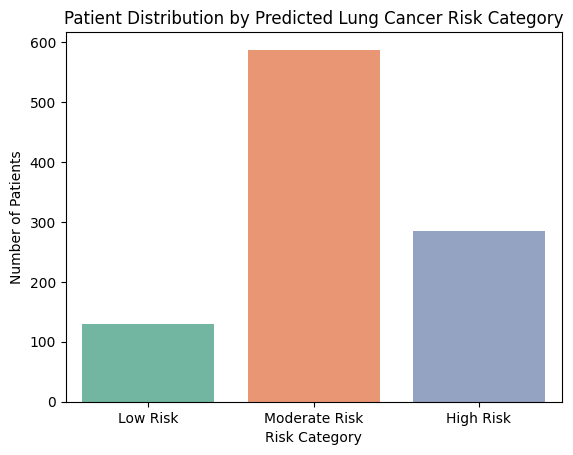

In [29]:
# Step 16: Predict for ALL Patients in the Dataset (Risk Labels and Confidence)
X_full = df.drop(["Patient Id", "Level"], axis=1)
X_scaled_all = scaler.transform(X_full)

pred_all = best_model.predict(X_scaled_all)
proba_all = best_model.predict_proba(X_scaled_all)

# Assign risk labels based on class probabilities
max_probs = proba_all.max(axis=1)
risk_labels = pd.cut(max_probs,
                     bins=[0, 0.6, 0.85, 1.0],
                     labels=["Low Risk", "Moderate Risk", "High Risk"])

# Save back to DataFrame
df["Predicted_Level"] = pred_all
df["Prediction_Confidence"] = (max_probs * 100).round(2)
df["Risk_Category"] = risk_labels

# Show first 10 predictions
print("\n🧪 Sample Predictions with Risk Category:")
display(df[["Patient Id", "Age", "Predicted_Level", "Risk_Category", "Prediction_Confidence"]].head(10))

# Step 17: Plot Risk Category Distribution
sns.countplot(data=df, x="Risk_Category", palette="Set2")
plt.title("Patient Distribution by Predicted Lung Cancer Risk Category")
plt.xlabel("Risk Category")
plt.ylabel("Number of Patients")
plt.show()